# Classification of different types of ASD subtypes


📦 Processing site: ABIDE1
[ABIDE1] Merged: 813 | Label counts: {0: 453, 1: 257, 2: 74, 3: 29}

📦 Processing site: IP
[IP] Merged: 35 | Label counts: {1: 22, 2: 13}

📦 Processing site: BNI
[BNI] Merged: 0 | Label counts: {}

📦 Processing site: NYU1
[NYU1] Merged: 46 | Label counts: {1: 19, 0: 16, 2: 9, 3: 2}

📦 Processing site: NYU2
[NYU2] Merged: 15 | Label counts: {0: 15}

📦 Processing site: SDSU
[SDSU] Merged: 0 | Label counts: {}

=== DATA QUALITY ===
Total samples: 909 | Features: 800
Class distribution: Counter({0: 484, 1: 298, 2: 96, 3: 31})
Site distribution: Counter({'ABIDE1': 813, 'NYU1': 46, 'IP': 35, 'NYU2': 15})

=== SIMPLE MODEL EVALUATION ===
Features after removing constants: 800

Configuration                       Train Acc  Test Acc   CV Acc    
----------------------------------------------------------------------
PCA_50_Random Forest                1.000      0.549      0.529
PCA_50_Gradient Boosting            1.000      0.516      0.512
PCA_50_Logistic Regression

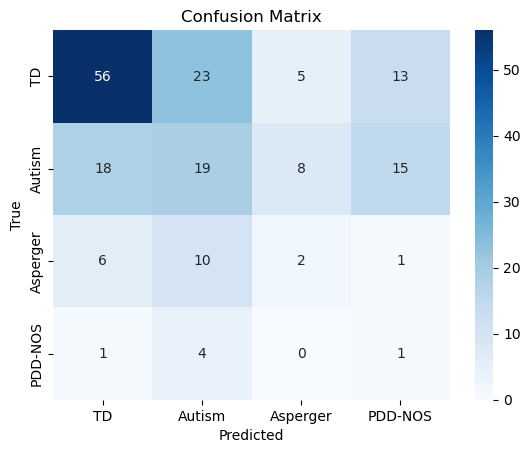

SelectK_PCA_Random Forest           1.000      0.549      0.509
SelectK_PCA_Gradient Boosting       1.000      0.489      0.474
SelectK_PCA_Logistic Regression     0.528      0.429      0.387

✅ Done with evaluation!


In [7]:
import os
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ====== Step 1: Load SDI data and labels ======
def load_combined_sdi_data(sites):
    X_combined, y_combined, site_labels = [], [], []

    for site, paths in sites.items():
        print(f"\n📦 Processing site: {site}")
        fc_file = paths['fc_sdi']
        sc_file = paths.get('sc_sdi')
        phenotype_file = paths['phenotype']

        if not os.path.exists(fc_file) or not os.path.exists(phenotype_file):
            print(f"[Warning] Missing files for site: {site}")
            continue

        try:
            df_fc = pd.read_csv(fc_file)
            df_fc.columns = [col.strip().lower() for col in df_fc.columns]
            id_fc = next((col for col in df_fc.columns if col in ['subject_id', 'patientid', 'sub_id']), None)
            df_fc.rename(columns={id_fc: 'subject_id'}, inplace=True)
            df_fc['subject_id'] = df_fc['subject_id'].astype(str)

            if sc_file and os.path.exists(sc_file):
                df_sc = pd.read_csv(sc_file)
                df_sc.columns = [col.strip().lower() for col in df_sc.columns]
                id_sc = next((col for col in df_sc.columns if col in ['subject_id', 'patientid', 'sub_id']), None)
                df_sc.rename(columns={id_sc: 'subject_id'}, inplace=True)
                df_sc['subject_id'] = df_sc['subject_id'].astype(str)
                df_merge = pd.merge(df_sc, df_fc, on='subject_id', suffixes=('_sc', '_fc'))
            else:
                fc_features = df_fc.drop(columns=['subject_id']).select_dtypes(include=[np.number])
                sc_zeros = pd.DataFrame(0, index=fc_features.index, columns=[f'dummy_sc_{i}' for i in range(fc_features.shape[1])])
                df_merge = pd.concat([sc_zeros, fc_features], axis=1)
                df_merge['subject_id'] = df_fc['subject_id']

            df_pheno = pd.read_csv(phenotype_file)
            df_pheno.columns = [col.strip().lower() for col in df_pheno.columns]
            id_pheno = next((col for col in df_pheno.columns if col in ['subject_id', 'patientid', 'sub_id']), None)
            df_pheno.rename(columns={id_pheno: 'subject_id'}, inplace=True)
            df_pheno['subject_id'] = df_pheno['subject_id'].astype(str)

            if site == 'ABIDE1' and 'dsm_iv_tr' in df_pheno.columns:
                df_pheno = df_pheno[['subject_id', 'dsm_iv_tr']].dropna()
                df_pheno = df_pheno[df_pheno['dsm_iv_tr'].isin([0, 1, 2, 3])]
                df_pheno['label'] = df_pheno['dsm_iv_tr'].map({0: 0, 1: 1, 2: 2, 3: 3})
            elif 'pdd_dsm_iv_tr' in df_pheno.columns:
                df_pheno = df_pheno[['subject_id', 'pdd_dsm_iv_tr']].dropna()
                df_pheno = df_pheno[df_pheno['pdd_dsm_iv_tr'].isin([0, 1, 2, 3])]
                df_pheno['label'] = df_pheno['pdd_dsm_iv_tr'].map({3: 0, 0: 1, 1: 2, 2: 3})
            else:
                print(f"[{site}] No valid DSM/PDD diagnostic info.")
                continue

            df_merge = pd.merge(df_merge, df_pheno[['subject_id', 'label']], on='subject_id')
            print(f"[{site}] Merged: {len(df_merge)} | Label counts: {dict(df_merge['label'].value_counts())}")

            features = df_merge.drop(columns=['subject_id', 'label']).select_dtypes(include=[np.number])
            features = features.fillna(features.median())

            inf_mask = np.isinf(features.values).any(axis=1)
            if inf_mask.any():
                features = features[~inf_mask]
                df_merge = df_merge[~inf_mask]

            X_combined.append(features.values)
            y_combined.append(df_merge['label'].values)
            site_labels.extend([site] * len(df_merge))

        except Exception as e:
            print(f"[Error] {site}: {e}")
            continue

    if not X_combined:
        print("❌ No data loaded. Please check paths and file integrity.")
        return np.array([]), np.array([]), []

    return np.vstack(X_combined), np.concatenate(y_combined), site_labels

# ====== Step 2: Data Quality Check ======
def assess_data_quality(X, y, site_labels):
    print("\n=== DATA QUALITY ===")
    print(f"Total samples: {len(y)} | Features: {X.shape[1]}")
    print(f"Class distribution: {Counter(y)}")
    print(f"Site distribution: {Counter(site_labels)}")
    return y

# ====== Step 3: Pipeline ======
def create_pipeline(preprocessing_type, model, n_features):
    steps = [('scaler', StandardScaler())]

    if preprocessing_type == 'PCA_50':
        steps.append(('pca', PCA(n_components=min(50, n_features-1), random_state=42)))
    elif preprocessing_type == 'PCA_100':
        steps.append(('pca', PCA(n_components=min(100, n_features-1), random_state=42)))
    elif preprocessing_type == 'SelectK_50':
        steps.append(('selector', SelectKBest(f_classif, k=min(50, n_features))))
    elif preprocessing_type == 'SelectK_PCA':
        steps.append(('selector', SelectKBest(f_classif, k=min(200, n_features))))
        steps.append(('pca', PCA(n_components=50, random_state=42)))

    steps.append(('smote', SMOTE(random_state=42, sampling_strategy='not majority', k_neighbors=1)))
    steps.append(('classifier', model))
    return ImbPipeline(steps)

# ====== Step 4: Models ======
def create_models():
    return {
        'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, class_weight='balanced'),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42),
        'Logistic Regression': LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced', multi_class='multinomial', solver='lbfgs')
    }

# ====== Step 5: Evaluation ======
def simple_evaluation(X, y):
    print("\n=== SIMPLE MODEL EVALUATION ===")
    print("=" * 60)

    X = X[:, np.var(X, axis=0) > 1e-8]
    print(f"Features after removing constants: {X.shape[1]}")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    preprocessing_methods = ['PCA_50', 'PCA_100', 'SelectK_50', 'SelectK_PCA']
    models = create_models()
    results = []

    print(f"\n{'Configuration':<35} {'Train Acc':<10} {'Test Acc':<10} {'CV Acc':<10}")
    print("-" * 70)

    for prep_name in preprocessing_methods:
        for model_name, model in models.items():
            config_name = f"{prep_name}_{model_name}"
            try:
                pipeline = create_pipeline(prep_name, model, X_train.shape[1])
                pipeline.fit(X_train, y_train)
                y_train_pred = pipeline.predict(X_train)
                y_test_pred = pipeline.predict(X_test)
                train_acc = accuracy_score(y_train, y_train_pred)
                test_acc = accuracy_score(y_test, y_test_pred)

                cv_scores = cross_val_score(pipeline, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy', n_jobs=-1)
                cv_acc = cv_scores.mean()

                print(f"{config_name:<35} {train_acc:.3f}      {test_acc:.3f}      {cv_acc:.3f}")
                results.append({'config': config_name, 'train_acc': train_acc, 'test_acc': test_acc, 'cv_acc': cv_acc, 'cv_std': cv_scores.std()})

                if config_name == 'SelectK_50_Logistic Regression':
                    print("\n📊 Classification Report (Logistic Regression, SelectK_50):")
                    print(classification_report(y_test, y_test_pred, digits=3, target_names=['TD', 'Autism', 'Asperger', 'PDD-NOS']))
                    cm = confusion_matrix(y_test, y_test_pred)
                    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['TD', 'Autism', 'Asperger', 'PDD-NOS'], yticklabels=['TD', 'Autism', 'Asperger', 'PDD-NOS'])
                    plt.title('Confusion Matrix')
                    plt.xlabel('Predicted')
                    plt.ylabel('True')
                    plt.show()

            except Exception as e:
                print(f"{config_name:<35} ERROR: {str(e)[:20]}...")
                continue

    return results

# ====== Main ======
def main():
    site_paths = {
        'ABIDE1': {
            'fc_sdi': '/Users/arnavkarnik/Documents/Classification/results_ABIDE1FC/sdi_informed_energy_normalized_abide1.csv',
            'phenotype': '/Users/arnavkarnik/Documents/Classification/Phenotypes_ABIDE1/Phenotypic_V1_0b_preprocessed1.csv'
        },
        'IP': {
            'fc_sdi': '/Users/arnavkarnik/Documents/Classification/results_ABIDE2FC/sdi_informed_energy_normalized_ip.csv',
            'sc_sdi': '/Users/arnavkarnik/Documents/Classification/results_ABIDE2SC/sdi_informed_energy_normalized_ip.csv',
            'phenotype': '/Users/arnavkarnik/Documents/Classification/Phenotypes_ABIDE2/IP_1_phenotypes.csv'
        },
        'BNI': {
            'fc_sdi': '/Users/arnavkarnik/Documents/Classification/results_ABIDE2FC/sdi_informed_energy_normalized_bni.csv',
            'sc_sdi': '/Users/arnavkarnik/Documents/Classification/results_ABIDE2SC/sdi_informed_energy_normalized_bni.csv',
            'phenotype': '/Users/arnavkarnik/Documents/Classification/Phenotypes_ABIDE2/BNI_1_phenotypes.csv'
        },
        'NYU1': {
            'fc_sdi': '/Users/arnavkarnik/Documents/Classification/results_ABIDE2FC/sdi_informed_energy_normalized_nyu1.csv',
            'sc_sdi': '/Users/arnavkarnik/Documents/Classification/results_ABIDE2SC/sdi_informed_energy_normalized_nyu1.csv',
            'phenotype': '/Users/arnavkarnik/Documents/Classification/Phenotypes_ABIDE2/NYU_1_phenotypes.csv'
        },
        'NYU2': {
            'fc_sdi': '/Users/arnavkarnik/Documents/Classification/results_ABIDE2FC/sdi_informed_energy_normalized_nyu2.csv',
            'sc_sdi': '/Users/arnavkarnik/Documents/Classification/results_ABIDE2SC/sdi_informed_energy_normalized_nyu2.csv',
            'phenotype': '/Users/arnavkarnik/Documents/Classification/Phenotypes_ABIDE2/NYU_2_phenotypes.csv'
        },
        'SDSU': {
            'fc_sdi': '/Users/arnavkarnik/Documents/Classification/results_ABIDE2FC/sdi_informed_energy_normalized_sdsu.csv',
            'sc_sdi': '/Users/arnavkarnik/Documents/Classification/results_ABIDE2SC/sdi_informed_energy_normalized_sdsu.csv',
            'phenotype': '/Users/arnavkarnik/Documents/Classification/Phenotypes_ABIDE2/SDSU_1_phenotypes.csv'
        }
    }

    X, y, site_labels = load_combined_sdi_data(site_paths)
    if X.size == 0:
        return

    y = assess_data_quality(X, y, site_labels)
    results = simple_evaluation(X, y)

    if results:
        print("\n✅ Done with evaluation!")
    else:
        print("\n❌ No successful models!")

if __name__ == '__main__':
    main()


In [7]:
import os
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# ====== 4-Class Label Mapping Functions ======
def process_abide1_labels(df_pheno):
    """Process ABIDE1 phenotype with DSM_IV_TR column"""
    print(f"[ABIDE1] Original phenotype shape: {df_pheno.shape}")
    
    if 'dsm_iv_tr' not in df_pheno.columns:
        print("[ABIDE1] DSM_IV_TR column not found")
        return df_pheno, None
    
    # DSM_IV_TR coding: 0=TD, 1=Autism, 2=Asperger, 3=PDD-NOS, -9999=Missing
    valid_dsm = df_pheno['dsm_iv_tr'].isin([0, 1, 2, 3])
    df_filtered = df_pheno[valid_dsm].copy()
    
    print(f"[ABIDE1] Using DSM_IV_TR: {df_filtered['dsm_iv_tr'].value_counts().to_dict()}")
    
    # Map to our 4-class system: 0=TD, 1=Autism, 2=Asperger, 3=PDD-NOS
    label_mapping = {0: 0, 1: 1, 2: 2, 3: 3}
    df_filtered['label'] = df_filtered['dsm_iv_tr'].map(label_mapping)
    
    print(f"[ABIDE1] Phenotype after processing: {len(df_filtered)}")
    
    return df_filtered, df_filtered['label'].value_counts().to_dict()

def process_abide2_pdd_labels(df_pheno, site_name):
    """Process ABIDE2 sites with PDD_DSM_IV_TR column"""
    print(f"[{site_name}] Original phenotype shape: {df_pheno.shape}")
    
    if 'pdd_dsm_iv_tr' not in df_pheno.columns:
        print(f"[{site_name}] PDD_DSM_IV_TR column not found")
        return df_pheno, None
    
    # Check PDD column data type and values
    pdd_col = df_pheno['pdd_dsm_iv_tr']
    print(f"[{site_name}] PDD column type: {pdd_col.dtype}")
    print(f"[{site_name}] Sample PDD values: {pdd_col.dropna().head().tolist()}")
    
    # Filter valid PDD values
    valid_pdd = df_pheno['pdd_dsm_iv_tr'].notna()
    df_filtered = df_pheno[valid_pdd].copy()
    
    print(f"[{site_name}] Valid PDD values found: {len(df_filtered)}")
    
    if len(df_filtered) == 0:
        return df_pheno, None
    
    # PDD_DSM_IV_TR coding varies by site, need to map consistently
    pdd_counts = df_filtered['pdd_dsm_iv_tr'].value_counts().to_dict()
    print(f"[{site_name}] Using PDD_DSM_IV_TR: {pdd_counts}")
    
    # Based on your analysis: 0=Autism, 1=Asperger, 2=PDD-NOS, 3=TD
    # Map to our standard: 0=TD, 1=Autism, 2=Asperger, 3=PDD-NOS
    label_mapping = {0: 1, 1: 2, 2: 3, 3: 0}  # PDD -> Standard
    df_filtered['label'] = df_filtered['pdd_dsm_iv_tr'].map(label_mapping)
    
    # Remove any unmapped values
    df_filtered = df_filtered.dropna(subset=['label'])
    df_filtered['label'] = df_filtered['label'].astype(int)
    
    print(f"[{site_name}] Mapped to labels: {df_filtered['label'].value_counts().to_dict()}")
    print(f"[{site_name}] Phenotype after processing: {len(df_filtered)}")
    
    return df_filtered, df_filtered['label'].value_counts().to_dict()

def process_abide2_dx_group_labels(df_pheno, site_name):
    """Process ABIDE2 sites with only DX_GROUP (fallback to binary)"""
    print(f"[{site_name}] Original phenotype shape: {df_pheno.shape}")
    print(f"[{site_name}] Using DX_GROUP: {df_pheno['dx_group'].value_counts().to_dict()}")
    
    # Map DX_GROUP to binary: 1=ASD, 2=TD -> 1=Autism, 0=TD
    # For 4-class, we'll treat all ASD as "Autism" subtype
    label_mapping = {1: 1, 2: 0}  # 1=Autism, 0=TD (no subtype info available)
    df_pheno['label'] = df_pheno['dx_group'].map(label_mapping)
    
    # Remove unmapped values
    df_filtered = df_pheno.dropna(subset=['label']).copy()
    df_filtered['label'] = df_filtered['label'].astype(int)
    
    print(f"[{site_name}] Mapped to labels: {df_filtered['label'].value_counts().to_dict()}")
    print(f"[{site_name}] Phenotype after processing: {len(df_filtered)}")
    
    return df_filtered, df_filtered['label'].value_counts().to_dict()

# ====== Enhanced Data Loading for 4-Class ======
def load_combined_sdi_data_4class(sites):
    """Load data with 4-class labels: 0=TD, 1=Autism, 2=Asperger, 3=PDD-NOS"""
    X_combined, y_combined, site_labels = [], [], []

    for site, paths in sites.items():
        print(f"\nProcessing site: {site}")
        fc_file = paths['fc_sdi']
        sc_file = paths.get('sc_sdi')
        phenotype_file = paths['phenotype']

        if not os.path.exists(fc_file) or not os.path.exists(phenotype_file):
            print(f"[Warning] Missing files for site: {site}")
            continue

        try:
            # Load FC data
            df_fc = pd.read_csv(fc_file)
            df_fc.columns = [col.strip().lower() for col in df_fc.columns]
            id_fc = next((col for col in df_fc.columns if col in ['subject_id', 'patientid', 'sub_id']), None)
            df_fc.rename(columns={id_fc: 'subject_id'}, inplace=True)
            df_fc['subject_id'] = df_fc['subject_id'].astype(str)

            # Load SC data if available
            if sc_file and os.path.exists(sc_file):
                df_sc = pd.read_csv(sc_file)
                df_sc.columns = [col.strip().lower() for col in df_sc.columns]
                id_sc = next((col for col in df_sc.columns if col in ['subject_id', 'patientid', 'sub_id']), None)
                df_sc.rename(columns={id_sc: 'subject_id'}, inplace=True)
                df_sc['subject_id'] = df_sc['subject_id'].astype(str)
                df_merge = pd.merge(df_sc, df_fc, on='subject_id', suffixes=('_sc', '_fc'))
            else:
                # For sites with only FC: create dummy SC features
                fc_features = df_fc.drop(columns=['subject_id']).select_dtypes(include=[np.number])
                sc_zeros = pd.DataFrame(0, index=fc_features.index, 
                                      columns=[f'dummy_sc_{i}' for i in range(fc_features.shape[1])])
                df_merge = pd.concat([sc_zeros, fc_features], axis=1)
                df_merge['subject_id'] = df_fc['subject_id']

            # Load and process phenotype data
            df_pheno = pd.read_csv(phenotype_file)
            df_pheno.columns = [col.strip().lower() for col in df_pheno.columns]
            id_pheno = next((col for col in df_pheno.columns if col in ['subject_id', 'patientid', 'sub_id']), None)
            df_pheno.rename(columns={id_pheno: 'subject_id'}, inplace=True)
            df_pheno['subject_id'] = df_pheno['subject_id'].astype(str)

            # Process labels based on site type
            if site == 'ABIDE1':
                df_pheno_processed, label_counts = process_abide1_labels(df_pheno)
            elif 'pdd_dsm_iv_tr' in df_pheno.columns:
                df_pheno_processed, label_counts = process_abide2_pdd_labels(df_pheno, site)
            else:
                df_pheno_processed, label_counts = process_abide2_dx_group_labels(df_pheno, site)
            
            if label_counts is None:
                print(f"[{site}] No valid labels found, skipping site")
                continue

            # Merge with features
            df_pheno_processed = df_pheno_processed[['subject_id', 'label']].drop_duplicates()
            df_final = pd.merge(df_merge, df_pheno_processed, on='subject_id')

            print(f"[{site}] Merged: {len(df_final)} | Label counts: {df_final['label'].value_counts().to_dict()}")

            # Clean features
            features = df_final.drop(columns=['subject_id', 'label']).select_dtypes(include=[np.number])
            features = features.fillna(features.median())
            
            # Remove rows with infinite values
            inf_mask = np.isinf(features.values).any(axis=1)
            if inf_mask.any():
                features = features[~inf_mask]
                df_final = df_final[~inf_mask]
                print(f"[{site}] Removed {inf_mask.sum()} rows with infinite values")

            if len(df_final) > 0:
                X_combined.append(features.values)
                y_combined.append(df_final['label'].values)
                site_labels.extend([site] * len(df_final))

        except Exception as e:
            print(f"[Error] {site}: {e}")
            continue

    if not X_combined:
        print("ERROR: No data loaded for 4-class classification")
        return np.array([]), np.array([]), []

    return np.vstack(X_combined), np.concatenate(y_combined), site_labels

# ====== Advanced Feature Engineering ======
def advanced_feature_engineering_4class(X, threshold=0.95):
    """Enhanced feature engineering for 4-class problem"""
    print(f"Advanced Feature Engineering...")
    print(f"   Original features: {X.shape[1]}")
    
    # Remove constant features
    feature_vars = np.var(X, axis=0)
    constant_mask = feature_vars > 1e-8
    X_filtered = X[:, constant_mask]
    removed_constant = X.shape[1] - X_filtered.shape[1]
    if removed_constant > 0:
        print(f"   Removed {removed_constant} constant features")
    
    # Remove highly correlated features
    if X_filtered.shape[1] > 1:
        corr_matrix = np.corrcoef(X_filtered.T)
        
        # Find pairs of highly correlated features
        high_corr_pairs = np.where(np.abs(corr_matrix) > threshold)
        high_corr_pairs = [(i, j) for i, j in zip(high_corr_pairs[0], high_corr_pairs[1]) if i < j]
        
        to_remove = set()
        for i, j in high_corr_pairs:
            # Keep the feature with higher variance
            if np.var(X_filtered[:, i]) > np.var(X_filtered[:, j]):
                to_remove.add(j)
            else:
                to_remove.add(i)
        
        keep_indices = [i for i in range(X_filtered.shape[1]) if i not in to_remove]
        X_final = X_filtered[:, keep_indices]
        print(f"   Removed {len(to_remove)} highly correlated features")
        print(f"   Features: {X.shape[1]} -> {X_final.shape[1]}")
        
        return X_final
    
    return X_filtered

# ====== 4-Class Models ======
def create_4class_models():
    """Create models optimized for 4-class classification"""
    
    models = {
        'Logistic Regression': LogisticRegression(
            max_iter=5000, 
            random_state=42, 
            class_weight='balanced',
            C=0.1,
            multi_class='ovr'  # One-vs-Rest for 4-class
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=500,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=500,
            learning_rate=0.03,
            max_depth=6,
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=42
        ),
        'XGBoost': xgb.XGBClassifier(
            n_estimators=500,
            learning_rate=0.03,
            max_depth=6,
            min_child_weight=3,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            eval_metric='mlogloss',
            objective='multi:softprob'
        ),
        'SVM': SVC(
            kernel='rbf',
            C=1.0,
            gamma='scale',
            class_weight='balanced',
            random_state=42,
            probability=True
        )
    }
    
    return models

# ====== 4-Class Pipeline Creation ======
def create_4class_pipeline(preprocessing_type, model, n_features):
    """Create pipelines optimized for 4-class imbalanced classification"""
    
    if preprocessing_type == 'PCA_4Class':
        # Conservative PCA for 4-class
        n_components = min(150, n_features//2)
        pipeline = ImbPipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=n_components, random_state=42)),
            ('sampler', SMOTE(random_state=42, k_neighbors=3)),  # Smaller k for minority classes
            ('classifier', model)
        ])
        
    elif preprocessing_type == 'SelectK_4Class':
        # Feature selection for 4-class
        k_features = min(200, n_features//2)
        pipeline = ImbPipeline([
            ('scaler', StandardScaler()),
            ('selector', SelectKBest(f_classif, k=k_features)),
            ('sampler', SMOTE(random_state=42, k_neighbors=3)),
            ('classifier', model)
        ])
        
    elif preprocessing_type == 'Hybrid_4Class':
        # Hybrid approach for 4-class
        pipeline = ImbPipeline([
            ('scaler', StandardScaler()),
            ('selector', SelectKBest(f_classif, k=min(300, n_features))),
            ('pca', PCA(n_components=100, random_state=42)),
            ('sampler', SMOTE(random_state=42, k_neighbors=3)),
            ('classifier', model)
        ])
        
    elif preprocessing_type == 'Conservative_4Class':
        # Conservative approach - minimal preprocessing
        pipeline = ImbPipeline([
            ('scaler', StandardScaler()),
            ('selector', SelectKBest(f_classif, k=min(100, n_features))),
            ('sampler', SMOTE(random_state=42, k_neighbors=2)),  # Very conservative
            ('classifier', model)
        ])
    
    return pipeline

# ====== 4-Class Evaluation ======
def evaluate_4class_classification(X, y, site_labels):
    """Comprehensive evaluation for 4-class classification"""
    
    print("\n=== 4-CLASS ASD SUBTYPE CLASSIFICATION ===")
    print("=" * 70)
    
    # Check class distribution
    class_counts = Counter(y)
    print(f"Class distribution: {class_counts}")
    
    # Check if we have enough samples for each class
    min_class_size = min(class_counts.values())
    if min_class_size < 5:
        print(f"Warning: Minimum class size is {min_class_size}. Results may be unreliable.")
    
    # Apply feature engineering
    X_engineered = advanced_feature_engineering_4class(X, threshold=0.95)
    
    # Stratified split ensuring all classes in train/test
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X_engineered, y, test_size=0.2, random_state=42, stratify=y
        )
    except ValueError as e:
        print(f"Stratification failed: {e}")
        print("Using random split without stratification")
        X_train, X_test, y_train, y_test = train_test_split(
            X_engineered, y, test_size=0.2, random_state=42
        )
    
    preprocessing_methods = ['PCA_4Class', 'SelectK_4Class', 'Hybrid_4Class', 'Conservative_4Class']
    models = create_4class_models()
    
    results = []
    
    print(f"\n{'Configuration':<40} {'Train Acc':<10} {'Test Acc':<10} {'Bal Acc':<10} {'CV Acc':<10}")
    print("-" * 90)
    
    for prep_name in preprocessing_methods:
        for model_name, model in models.items():
            config_name = f"{prep_name}_{model_name}"
            
            try:
                # Create pipeline
                pipeline = create_4class_pipeline(prep_name, model, X_train.shape[1])
                
                # Training
                pipeline.fit(X_train, y_train)
                y_train_pred = pipeline.predict(X_train)
                train_acc = accuracy_score(y_train, y_train_pred)
                
                # Testing
                y_test_pred = pipeline.predict(X_test)
                test_acc = accuracy_score(y_test, y_test_pred)
                bal_acc = balanced_accuracy_score(y_test, y_test_pred)
                
                # Cross-validation with careful handling of small classes
                cv_folds = min(5, min_class_size)  # Reduce folds if classes are small
                if cv_folds < 3:
                    cv_acc = test_acc  # Fallback to test accuracy
                    cv_std = 0.0
                else:
                    try:
                        cv_scores = cross_val_score(
                            pipeline, X_engineered, y, 
                            cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42),
                            scoring='balanced_accuracy', 
                            n_jobs=-1
                        )
                        cv_acc = cv_scores.mean()
                        cv_std = cv_scores.std()
                    except:
                        cv_acc = test_acc
                        cv_std = 0.0
                
                results.append({
                    'config': config_name,
                    'train_acc': train_acc,
                    'test_acc': test_acc,
                    'bal_acc': bal_acc,
                    'cv_acc': cv_acc,
                    'cv_std': cv_std
                })
                
                print(f"{config_name:<40} {train_acc:.3f}      {test_acc:.3f}      {bal_acc:.3f}      {cv_acc:.3f}")
                
            except Exception as e:
                print(f"{config_name:<40} ERROR: {str(e)[:30]}...")
                continue
    
    # Results summary
    if results:
        results_df = pd.DataFrame(results)
        results_df = results_df.sort_values('cv_acc', ascending=False)
        
        print("\n" + "=" * 90)
        print("BEST PERFORMING 4-CLASS MODELS")
        print("=" * 90)
        
        # Best model
        best = results_df.iloc[0]
        print(f"\nBest 4-Class Model: {best['config']}")
        print(f"  Training Accuracy:   {best['train_acc']:.3f}")
        print(f"  Testing Accuracy:    {best['test_acc']:.3f}")
        print(f"  Balanced Accuracy:   {best['bal_acc']:.3f}")
        print(f"  CV Balanced Accuracy: {best['cv_acc']:.3f} ± {best['cv_std']:.3f}")
        
        # Top 5 models
        print(f"\nTop 5 4-Class Models:")
        for i, (_, row) in enumerate(results_df.head(5).iterrows(), 1):
            print(f"  {i}. {row['config']:<35} CV: {row['cv_acc']:.3f} ± {row['cv_std']:.3f}")
        
        return best['config'], results_df, X_engineered
    
    return None, None, X_engineered

# ====== Detailed 4-Class Analysis ======
def detailed_4class_analysis(X, y, best_config, site_labels):
    """Provide detailed analysis of 4-class results"""
    
    print(f"\n=== DETAILED 4-CLASS ANALYSIS ===")
    print("=" * 60)
    
    # Class distribution analysis
    class_counts = Counter(y)
    class_names = {0: 'TD', 1: 'Autism', 2: 'Asperger', 3: 'PDD-NOS'}
    
    print(f"\nFinal Class Distribution:")
    total_samples = len(y)
    for class_id, count in sorted(class_counts.items()):
        percentage = (count / total_samples) * 100
        print(f"  {class_names[class_id]}: {count} samples ({percentage:.1f}%)")
    
    # Site-wise class distribution
    print(f"\nSite-wise Distribution:")
    site_counter = Counter(site_labels)
    for site in site_counter.keys():
        site_mask = np.array(site_labels) == site
        site_classes = Counter(y[site_mask])
        print(f"  {site}: {dict(site_classes)}")
    
    # Train best model for detailed evaluation
    if best_config and len(set(y)) > 1:
        try:
            # Parse best config
            parts = best_config.split('_')
            prep_type = '_'.join(parts[:-2]) if len(parts) > 2 else parts[0]
            model_type = '_'.join(parts[-2:])
            
            models = create_4class_models()
            model = models.get(model_type)
            
            if model:
                pipeline = create_4class_pipeline(prep_type, model, X.shape[1])
                
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=0.2, random_state=42, stratify=y if len(set(y)) > 1 else None
                )
                
                pipeline.fit(X_train, y_train)
                y_pred = pipeline.predict(X_test)
                
                print(f"\nDetailed Classification Report:")
                target_names = [class_names[i] for i in sorted(set(y))]
                print(classification_report(y_test, y_pred, target_names=target_names, digits=3))
                
                print(f"\nConfusion Matrix:")
                cm = confusion_matrix(y_test, y_pred)
                print("Predicted ->")
                print(f"Actual   \\   {' '.join([f'{class_names[i]:>8}' for i in sorted(set(y))])}")
                for i, class_id in enumerate(sorted(set(y))):
                    row_str = f"{class_names[class_id]:>8}   "
                    row_str += ' '.join([f"{cm[i,j]:>8}" for j in range(len(set(y)))])
                    print(row_str)
                
        except Exception as e:
            print(f"Detailed analysis failed: {e}")

# ====== Main Function ======
def main():
    """Main execution function for 4-class classification"""
    
    # Define site paths
    site_paths = {
        'ABIDE1': {
            'fc_sdi': '/Users/arnavkarnik/Documents/Classification/results_ABIDE1FC/sdi_informed_energy_normalized_abide1.csv',
            'phenotype': '/Users/arnavkarnik/Documents/Classification/Phenotypes_ABIDE1/Phenotypic_V1_0b_preprocessed1.csv'
        },
        'IP': {
            'fc_sdi': '/Users/arnavkarnik/Documents/Classification/results_ABIDE2FC/sdi_informed_energy_normalized_ip.csv',
            'sc_sdi': '/Users/arnavkarnik/Documents/Classification/results_ABIDE2SC/sdi_informed_energy_normalized_ip.csv',
            'phenotype': '/Users/arnavkarnik/Documents/Classification/Phenotypes_ABIDE2/IP_1_phenotypes.csv'
        },
        'BNI': {
            'fc_sdi': '/Users/arnavkarnik/Documents/Classification/results_ABIDE2FC/sdi_informed_energy_normalized_bni.csv',
            'sc_sdi': '/Users/arnavkarnik/Documents/Classification/results_ABIDE2SC/sdi_informed_energy_normalized_bni.csv',
            'phenotype': '/Users/arnavkarnik/Documents/Classification/Phenotypes_ABIDE2/BNI_1_phenotypes.csv'
        },
        'NYU1': {
            'fc_sdi': '/Users/arnavkarnik/Documents/Classification/results_ABIDE2FC/sdi_informed_energy_normalized_nyu1.csv',
            'sc_sdi': '/Users/arnavkarnik/Documents/Classification/results_ABIDE2SC/sdi_informed_energy_normalized_nyu1.csv',
            'phenotype': '/Users/arnavkarnik/Documents/Classification/Phenotypes_ABIDE2/NYU_1_phenotypes.csv'
        },
        'NYU2': {
            'fc_sdi': '/Users/arnavkarnik/Documents/Classification/results_ABIDE2FC/sdi_informed_energy_normalized_nyu2.csv',
            'sc_sdi': '/Users/arnavkarnik/Documents/Classification/results_ABIDE2SC/sdi_informed_energy_normalized_nyu2.csv',
            'phenotype': '/Users/arnavkarnik/Documents/Classification/Phenotypes_ABIDE2/NYU_2_phenotypes.csv'
        },
        'SDSU': {
            'fc_sdi': '/Users/arnavkarnik/Documents/Classification/results_ABIDE2FC/sdi_informed_energy_normalized_sdsu.csv',
            'sc_sdi': '/Users/arnavkarnik/Documents/Classification/results_ABIDE2SC/sdi_informed_energy_normalized_sdsu.csv',
            'phenotype': '/Users/arnavkarnik/Documents/Classification/Phenotypes_ABIDE2/SDSU_1_phenotypes.csv'
        }
    }

    print("Starting 4-Class ASD Subtype Classification")
    print("=" * 60)
    print("Classes: 0=TD, 1=Autism, 2=Asperger, 3=PDD-NOS")
    print("=" * 60)
    
    # Load data with 4-class labels
    X, y, site_labels = load_combined_sdi_data_4class(site_paths)
    if X.size == 0:
        return
    
    print(f"\nData loaded: {len(y)} samples, {X.shape[1]} features")
    print(f"Class distribution: {Counter(y)}")
    print(f"Site distribution: {Counter(site_labels)}")
    
    # Evaluate 4-class classification
    best_config, results_df, X_engineered = evaluate_4class_classification(X, y, site_labels)
    
    if best_config is None:
        print("4-Class evaluation failed!")
        return
    
    # Detailed analysis
    detailed_4class_analysis(X_engineered, y, best_config, site_labels)
    
    print(f"\n=== 4-CLASS SUMMARY ===")
    print(f"Best approach: {best_config}")
    print(f"Dataset: {len(y)} samples from {len(set(site_labels))} sites")
    if results_df is not None and len(results_df) > 0:
        best_score = results_df.iloc[0]['cv_acc']
        print(f"Best 4-class accuracy: {best_score:.3f}")

if __name__ == '__main__':
    main()

Starting 4-Class ASD Subtype Classification
Classes: 0=TD, 1=Autism, 2=Asperger, 3=PDD-NOS

Processing site: ABIDE1
[ABIDE1] Original phenotype shape: (1112, 106)
[ABIDE1] Using DSM_IV_TR: {0: 558, 1: 347, 2: 93, 3: 36}
[ABIDE1] Phenotype after processing: 1034
[ABIDE1] Merged: 813 | Label counts: {0: 453, 1: 257, 2: 74, 3: 29}

Processing site: IP
[IP] Original phenotype shape: (36, 349)
[IP] PDD column type: int64
[IP] Sample PDD values: [1, 1, 1, 2, 1]
[IP] Valid PDD values found: 36
[IP] Using PDD_DSM_IV_TR: {0: 22, 1: 13, 2: 1}
[IP] Mapped to labels: {1: 22, 2: 13, 3: 1}
[IP] Phenotype after processing: 36
[IP] Merged: 35 | Label counts: {1: 22, 2: 13}

Processing site: BNI
[BNI] Original phenotype shape: (57, 349)
[BNI] PDD column type: float64
[BNI] Sample PDD values: []
[BNI] Valid PDD values found: 0
[BNI] No valid labels found, skipping site

Processing site: NYU1
[NYU1] Original phenotype shape: (47, 349)
[NYU1] PDD column type: int64
[NYU1] Sample PDD values: [3, 1, 1, 3, 3